## Machine Learning Lista 04
### Douglas Gaspar Feitosa Freitas - 473552


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanAbsolutePercentageError
import keras_tuner as kt

# Carregar os dados
data = pd.read_csv('concrete.csv')

# Separar os atributos e a saída
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Dividir os dados em treino, validação e teste
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Questão 01
Considere o conjunto de dados disponível em **concrete.csv**, organizado em 9 colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída. Os 8 atributos referem-se à caracterização de diferentes tipos de concreto para construção civil. A saída é a resistência à compressão do concreto (em megapascals, MPa). Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/d/4353

a) Considere um modelo de regressão não linear baseado em redes neurais artificiais. Separe os dados aleatoriamente em treino, validação e teste (por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo abaixo:
   – **MLP (multilayer perceptron)**: 1 camada oculta e treinamento em minibatch via gradiente descendente estocástico com termo de momentum. Utilize o conjunto de validação para ajustar os hiperparâmetros.

b) Apresente as curvas da função custo nos conjuntos de treinamento e validação ao longo das épocas. Reporte também para os conjuntos de treino, validação e teste as métricas abaixo:  
– **RMSE (root mean squared error)**;  
– **MAE (mean absolute error)**;  
– **MRE (mean relative error)**.

In [2]:
def build_model(hp):

    # Definir o modelo
    model = Sequential()

    # Otimizar o número de neurônios na camada oculta
    hp_units = hp.Int('units', min_value=5, max_value=125, step=5)
    hp_activ = hp.Choice("activation", values=["relu", "tanh"])
    hp_learn_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    hp_momentum = hp.Float('momentum', min_value=0.7, max_value=0.99, sampling='LOG')

    model.add(Dense(units=hp_units, input_dim=X_train.shape[1], activation=hp_activ))

    # Output
    model.add(Dense(units=1, activation = 'linear'))

    # Compilar o modelo com o otimizador SGD
    optimizer = SGD(learning_rate=hp_learn_rate, momentum=hp_momentum)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_error'])

    return model

# Configurar o Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_mean_squared_error", direction="min"),
    max_trials=500, #Isso demora demais, se for rodar de novo, se tens pena da tua CPU, bote um número até 100
    executions_per_trial=2,
    max_consecutive_failed_trials=500,
)

tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
             batch_size=32, callbacks=[early_stopping])

Trial 377 Complete [00h 00m 21s]
val_mean_squared_error: 42.66871452331543

Best val_mean_squared_error So Far: 28.480835914611816
Total elapsed time: 01h 41m 04s

Search: Running Trial #378

Value             |Best Value So Far |Hyperparameter
115               |90                |units
relu              |tanh              |activation
0.0046342         |0.003141          |learning_rate
0.71058           |0.84347           |momentum

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 818.2379 - mean_absolute_error: 22.9884 - mean_absolute_percentage_error: 67.5088 - mean_squared_error: 818.2379 - val_loss: 243.8087 - val_mean_absolute_error: 12.4797 - val_mean_absolute_percentage_error: 36.4180 - val_mean_squared_error: 243.8087
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 165.9834 - mean_absolute_error: 10.3234 - mean_absolute_percentage_error: 41.8157 - mean_squared_error: 165.9834 - val_loss: 138.6812 - val_mean_absolute_error: 9.3794 - val_mean_absolute_perce

KeyboardInterrupt: 

In [7]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Melhor número de neurônios: {best_hps.get('units')}")
print(f"Melhor taxa de aprendizado: {best_hps.get('learning_rate')}")

# Treine o modelo com os melhores hiperparâmetros
best_model = tuner.hypermodel.build(best_hps)

model = best_model

# Treinar o modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)

train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f"RMSE - Treino: {np.sqrt(train_loss[0])}, Validação: {np.sqrt(val_loss[0])}, Teste: {np.sqrt(test_loss[0])}")
print(f"MAE - Treino: {train_loss[1]}, Validação: {val_loss[1]}, Teste: {test_loss[1]}")
print(f"MRE - Treino: {train_loss[2]}, Validação: {val_loss[2]}, Teste: {test_loss[2]}")

Melhor número de neurônios: 90
Melhor taxa de aprendizado: 0.003140973580686
RMSE - Treino: 10.942265284467567, Validação: 12.451114123640577, Teste: 11.83445999441356
MAE - Treino: 8.38766860961914, Validação: 9.26596736907959, Teste: 9.26726245880127
MRE - Treino: 26.24055290222168, Validação: 25.978973388671875, Teste: 27.998380661010742


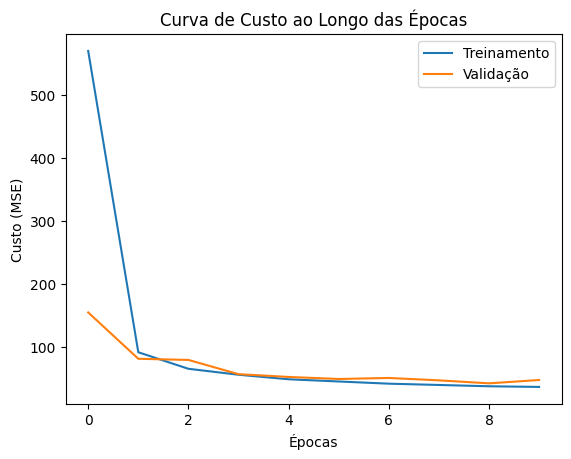

In [8]:
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Curva de Custo ao Longo das Épocas')
plt.xlabel('Épocas')
plt.ylabel('Custo (MSE)')
plt.legend()
plt.show()

## Questão 2
Considere o conjunto de dados disponível em **vowel.csv**, organizado em 11 colunas, sendo as 10 primeiras colunas os atributos e a última coluna a saída. Os 10 atributos referem-se à caracterização de amostras da fala de britânicos. A saída é o fonema de vogal correspondente, dentre as 11 possibilidades. Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/d/307.  
a) Considere um modelo de classificação não linear baseado em redes neurais artificiais. Separe os dados aleatoriamente em treino, validação e teste (por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo abaixo:  
– **MLP (multilayer perceptron)**: 1 camada oculta e treinamento em minibatch via gradiente descendente estocástico com termo de momentum. Utilize o conjunto de validação para ajustar os hiperparâmetros.  
b) Apresente as curvas da função custo nos conjuntos de treinamento e validação ao longo das épocas. Reporte também a acurácia obtida para os conjuntos de treino, validação e teste.

In [9]:
# Carregar os dados
data = pd.read_csv('vowel.csv')

# Separar os atributos e a saída
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Convertendo a saída para categorias (one-hot encoding)
y = tf.keras.utils.to_categorical(y, num_classes=11)

# Dividir os dados em treino, validação e teste
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

def build_model(hp):
    model = Sequential()

    # Otimizar o número de neurônios na camada oculta
    hp_units = hp.Int('units', min_value=8, max_value=128, step=8)
    model.add(Dense(units=hp_units, activation='relu', input_dim=X_train.shape[1]))

    # Camada de saída para classificação com softmax
    model.add(Dense(11, activation='softmax'))

    # Otimizar a taxa de aprendizado do otimizador
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')

    model.compile(optimizer=SGD(learning_rate=hp_learning_rate, momentum=0.9),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='vowel_classification_tuning'
)

tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
             batch_size=32, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Trial 10 Complete [00h 00m 23s]
val_accuracy: 0.9191919267177582

Best val_accuracy So Far: 0.9191919267177582
Total elapsed time: 00h 04m 00s


Melhor número de neurônios: 128
Melhor taxa de aprendizado: 0.004627602634393576
Acurácia no conjunto de treino: 0.9983136653900146
Acurácia no conjunto de validação: 0.939393937587738
Acurácia no conjunto de teste: 0.9191918969154358


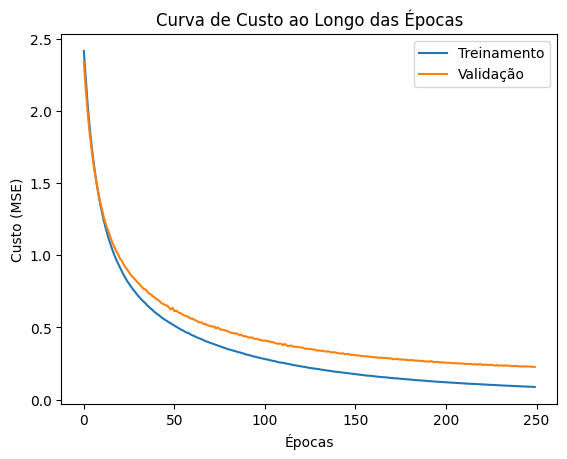

In [19]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Melhor número de neurônios: {best_hps.get('units')}")
print(f"Melhor taxa de aprendizado: {best_hps.get('learning_rate')}")

# Treina o modelo com os melhores hiperparâmetros
best_model = tuner.hypermodel.build(best_hps)
history2 = best_model.fit(X_train, y_train, epochs=250, validation_data=(X_val, y_val), batch_size=32, verbose=0)

train_loss, train_accuracy = best_model.evaluate(X_train, y_train, verbose=0)
val_loss, val_accuracy = best_model.evaluate(X_val, y_val, verbose=0)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

print(f"Acurácia no conjunto de treino: {train_accuracy}")
print(f"Acurácia no conjunto de validação: {val_accuracy}")
print(f"Acurácia no conjunto de teste: {test_accuracy}")

plt.plot(history2.history['loss'], label='Treinamento')
plt.plot(history2.history['val_loss'], label='Validação')
plt.title('Curva de Custo ao Longo das Épocas')
plt.xlabel('Épocas')
plt.ylabel('Custo (MSE)')
plt.legend()
plt.show()

Primeiro, que desgraça esse sklearn. Depois de sofrer muito com ele e lidar com DOIS PROBLEMAS reportados *há anos* (https://github.com/scikit-learn/scikit-learn/issues/24411, https://github.com/scikit-learn/scikit-learn/issues/13656), eu mudei pro Keras no literal último dia pra finalmente ter um resultado bom. Agora se tem uma coisa que o sklearn tinha melhor que o keras era a otimização dos hiperparâmetros, no sklearn eu fiz gridsearch e nem demorou tanto, no keras eu fiz random search na Q1 e demorou tudo isso aí que dá pra ver salvo no jupyter, na Q2 eu fiz uma random search bem mais tímida. E depois disso tudo agora às 22:42 eu percebi que esqueci de incluir batch_size entre os hiperparâmetros da busca :^)
Eu fiz a busca com mais hiperparâmetros nas versões com o sklearn que estão inclusas, se quiser ver. Mas os resultados nele não são bons.